# Other Census Bureau datasets

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/mmann1123/pytidycensus/blob/main/examples/04_other_datasets.ipynb)

Exploring Population Estimates and other Census datasets beyond ACS and Decennial Census.

In [ ]:
import pytidycensus as tc
import pandas as pd
import matplotlib.pyplot as plt

tc.set_census_api_key("YOUR API KEY GOES HERE")


## Not implemented in pytidycensus yet

Census API key has been set for this session.


## Population Estimates

The Population Estimates Program provides annual updates on population characteristics.

In [2]:
# Get population estimates for US states
us_pop_estimates = tc.get_estimates(
    geography="state",
    variables="POP",
    year=2022
)

print(f"Shape: {us_pop_estimates.shape}")
us_pop_estimates.head()

Getting data from the 2024 Population Estimates Program (vintage 2024)
Shape: (52, 3)


/home/mmann1123/miniconda3/envs/test2/lib/python3.11/site-packages/pytidycensus/estimates.py:518: UserWarning: Using vintage 2024 data for year 2022. Consider setting vintage=2022 if available.
  warnings.warn(


,GEOID,NAME,POPESTIMATE2022
14,01,Alabama,5076181
15,02,Alaska,734442
16,04,Arizona,7377566
17,05,Arkansas,3047704
18,06,California,39142414


## Components of Population Change

In [4]:
# Get components of change data
us_components = tc.get_estimates(
    geography="state",
    variables=["BIRTHS", "DEATHS", "DOMESTICMIG", "INTERNATIONALMIG"],
    year=2022
)

print("Available components of change:")
print(us_components['variable'].unique())
us_components

Getting data from the 2024 Population Estimates Program (vintage 2024)
Available components of change:
['BIRTHS2022' 'DEATHS2022' 'DOMESTICMIG2022' 'INTERNATIONALMIG2022']


/home/mmann1123/miniconda3/envs/test2/lib/python3.11/site-packages/pytidycensus/estimates.py:518: UserWarning: Using vintage 2024 data for year 2022. Consider setting vintage=2022 if available.
  warnings.warn(


,GEOID,NAME,variable,estimate
0,01,Alabama,BIRTHS2022,58103
1,02,Alaska,BIRTHS2022,9359
2,04,Arizona,BIRTHS2022,79173
3,05,Arkansas,BIRTHS2022,36115
4,06,California,BIRTHS2022,424071
...,...,...,...,...
203,53,Washington,INTERNATIONALMIG2022,43544
204,54,West Virginia,INTERNATIONALMIG2022,1673
205,55,Wisconsin,INTERNATIONALMIG2022,19693
206,56,Wyoming,INTERNATIONALMIG2022,551


## Mapping Population Estimates

Let's create a map of net migration rates:

In [7]:
# Get net migration for counties with geometry
net_migration = tc.get_estimates(
    geography="county",
    variables="RNETMIG",  # Net migration rate
    year=2022,
    geometry=True
)
net_migration.head()

/home/mmann1123/miniconda3/envs/test2/lib/python3.11/site-packages/pytidycensus/estimates.py:518: UserWarning: Using vintage 2024 data for year 2022. Consider setting vintage=2022 if available.
  warnings.warn(


Getting data from the 2024 Population Estimates Program (vintage 2024)
Loading county boundaries...


,GEOID,NAME_x,geometry,STATEFP,COUNTYFP,NAMELSAD,NAME_y,RNETMIG2022
0,31039,Cuming,"POLYGON ((-96.55516 41.91587, -96.55515 41.914...",31,039,Cuming County,"Cuming County, Nebraska",-2.672159
1,53069,Wahkiakum,"POLYGON ((-123.72755 46.2645, -123.72756 46.26...",53,069,Wahkiakum County,"Wahkiakum County, Washington",28.888649
2,35011,De Baca,"POLYGON ((-104.89337 34.08894, -104.89337 34.0...",35,011,De Baca County,"De Baca County, New Mexico",21.308079
3,31109,Lancaster,"POLYGON ((-96.68493 40.5233, -96.69219 40.5231...",31,109,Lancaster County,"Lancaster County, Nebraska",3.104867
4,31129,Nuckolls,"POLYGON ((-98.2737 40.1184, -98.27374 40.1224,...",31,129,Nuckolls County,"Nuckolls County, Nebraska",4.909783


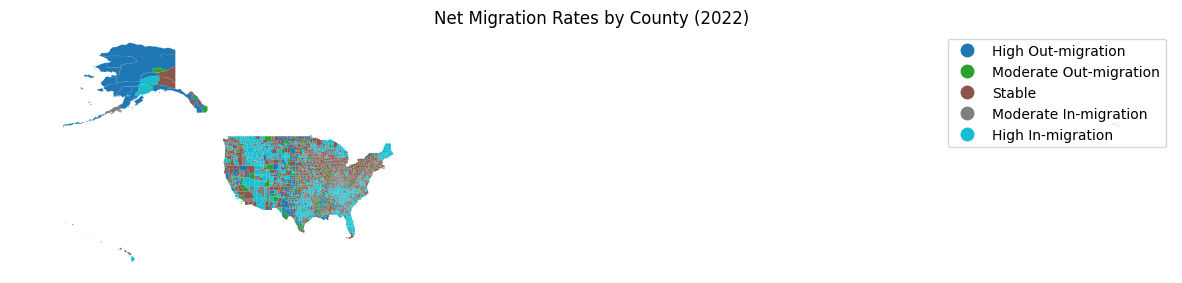

In [14]:
# Create migration categories
net_migration["migration_category"] = pd.cut(
    net_migration["RNETMIG2022"],
    bins=[-float("inf"), -10, -5, 5, 10, float("inf")],
    labels=[
        "High Out-migration",
        "Moderate Out-migration",
        "Stable",
        "Moderate In-migration",
        "High In-migration",
    ],
)

# Plot map
fig, ax = plt.subplots(figsize=(15, 20))
net_migration.plot(column="migration_category", legend=True, ax=ax)
ax.set_title("Net Migration Rates by County (2022)")
ax.set_axis_off()
plt.show()